<a href="https://colab.research.google.com/github/mlvlab/data303/blob/main/Image_Generation_by_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======

This example is derived from 1. 'Deep Learning for Graphics Tutorial'.

Resources:

1.  CreativeAI: Deep Learning for Graphics Tutorial [[Link]](https://github.com/smartgeometry-ucl/dl4g)
2.  debuggercafe.com [[Link]](https://debuggercafe.com/vanilla-gan-pytorch/)

In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image # for saving tensor images
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

### Hyperparameters


In [2]:
latent_dims = 100   # fixed size noise vector
num_epochs = 80
batch_size = 256
learning_rate = 2e-4
use_gpu = True

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")


### MNIST Data Loading

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.



In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(28),  # bilinear interpolation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))    # mean=0.5, std=0.5
])

train_dataset = MNIST(root='./data/MNIST_GAN_MLP', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST_GAN_MLP', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

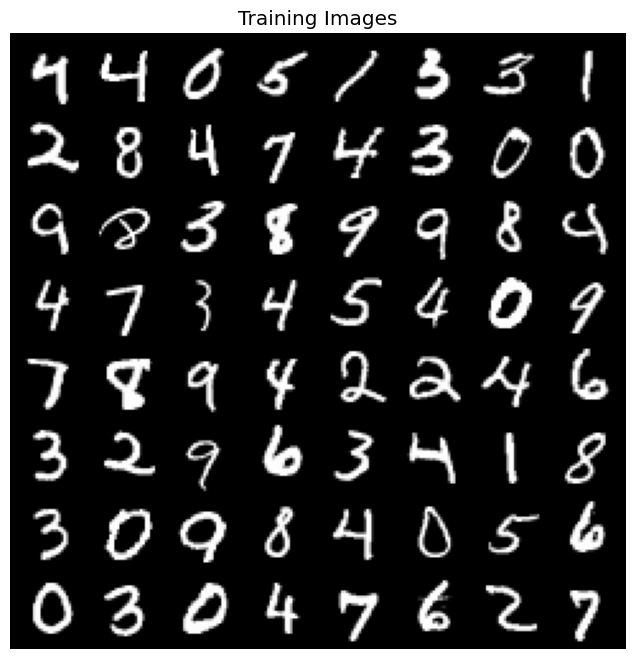

In [4]:
# some training samples
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
real_batch[0].to(device)[:64].shape

torch.Size([64, 1, 28, 28])

In [6]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### GAN Architecture
Like DCGAN, we use CNNs for generator and discriminator, which generally outperform vanilla GANs with fully connected layers.

In [9]:
# from pytorch.org - DCGAB Tutorial
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        

class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        
        # MLP (FC layers)
    
        # [batch_size, 100 -> 128]
        self.Linear1 = nn.Linear(latent_dims, d)
        # [batch_size, 128 -> 256]
        self.Linear2 = nn.Linear(d, d*2)
        # [batch_size, 256 -> 512]
        self.Linear3 = nn.Linear(d*2, d*4)
        # [batch_size, 512 -> 784]
        self.Linear4 = nn.Linear(d*4, 784)
        

    def forward(self, input):
        a = F.leaky_relu(self.Linear1(input), 0.2)
        a = F.leaky_relu(self.Linear2(a), 0.2)
        a = F.leaky_relu(self.Linear3(a), 0.2)
        a = torch.tanh(self.Linear4(a))
        # [batch_size, 784]
        return a


class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()

        # MLP (FC layers)
        # [batch_size, 784 -> 512]
        self.Linear1 = nn.Linear(784, d*4)
        # [batch_size, 512 -> 256]
        self.Linear2 = nn.Linear(d*4, d*2)
        # 256 -> 128
        self.Linear3 = nn.Linear(d*2, d)
        # 128 -> 1
        self.Linear4 = nn.Linear(d, 1)
        
        
    def forward(self, input):
        a = F.dropout(F.leaky_relu(self.Linear1(input), 0.2), 0.3)
        a = F.dropout(F.leaky_relu(self.Linear2(a), 0.2), 0.3)
        a = F.dropout(F.leaky_relu(self.Linear3(a), 0.2), 0.3)
        a = torch.sigmoid(self.Linear4(a))

        return a
    
generator = Generator() # generator output shape: [batch_size, 784]
discriminator = Discriminator() # discriminator output shape: [batch_size, 1]

generator = generator.to(device)
discriminator = discriminator.to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

Number of parameters for generator: 579,728 and discriminator: 566,273


In [10]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

# save sample images periodically to visualise progress

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        # flatten image batch to [batch_size, 784]
        real_image_batch = image_batch.view(image_batch.size(0), -1)
        label_real = torch.ones(image_batch.size(0), 1, device=device)
        label_fake = torch.zeros(image_batch.size(0), 1, device=device)

        # generate a batch of images from samples of the latent prior
        # latent.shape = (batch_size, latent_dims)
        latent = torch.randn(image_batch.size(0), latent_dims, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(real_image_batch)
        fake_pred = discriminator(fake_image_batch.detach())
        
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch)
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
    
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))
    
    # save a sample batch of images
    if (epoch+1)%2 == 0:
        with torch.no_grad():
            fake_image_batch = generator(latent).detach().cpu()[:64]
            fake_image_batch = fake_image_batch.view(64, 1, 28, 28)
            save_image(make_grid(fake_image_batch), f'images/MLP_GAN_epoch_{epoch+1}.png')
            


Training ...
Epoch [1 / 80] average loss generator vs. discrim.: 1.062587 vs. 0.486949
Epoch [2 / 80] average loss generator vs. discrim.: 3.280172 vs. 0.179800
Epoch [3 / 80] average loss generator vs. discrim.: 3.618860 vs. 0.207153
Epoch [4 / 80] average loss generator vs. discrim.: 3.996852 vs. 0.197516
Epoch [5 / 80] average loss generator vs. discrim.: 3.610120 vs. 0.192037
Epoch [6 / 80] average loss generator vs. discrim.: 3.677302 vs. 0.149772
Epoch [7 / 80] average loss generator vs. discrim.: 4.095125 vs. 0.141129
Epoch [8 / 80] average loss generator vs. discrim.: 4.204963 vs. 0.137984
Epoch [9 / 80] average loss generator vs. discrim.: 4.142216 vs. 0.138773
Epoch [10 / 80] average loss generator vs. discrim.: 3.723304 vs. 0.156139
Epoch [11 / 80] average loss generator vs. discrim.: 3.748366 vs. 0.118965
Epoch [12 / 80] average loss generator vs. discrim.: 3.474090 vs. 0.137746
Epoch [13 / 80] average loss generator vs. discrim.: 3.399714 vs. 0.137804
Epoch [14 / 80] avera

### Plot Training Curves

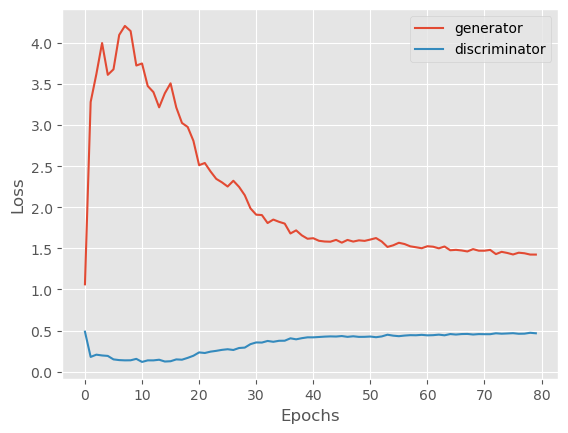

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

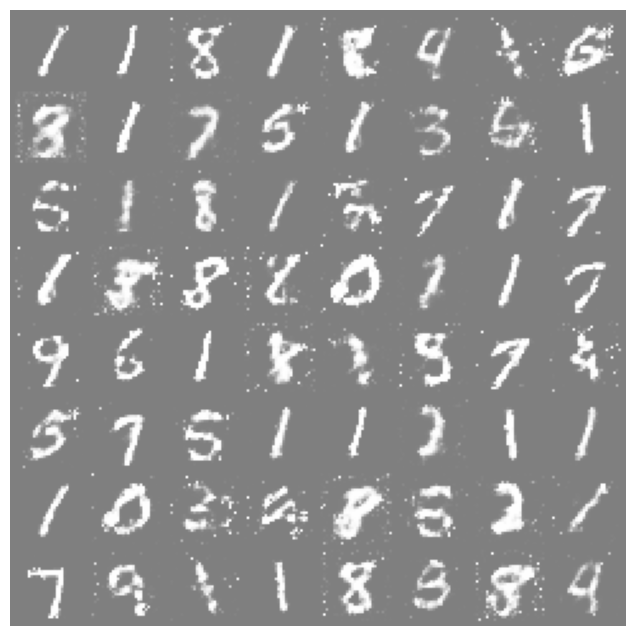

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -0.9998, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.9981, -0.9986, -0.9997,  ..., -1.0000, -1.0000, -0.9887],
          [-1.0000,  0.839

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(64, 100, device=device)
    fake_image_batch = generator(latent).view(64, 1, 28, 28)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch, padding=2, normalize=True))
    ax.axis('off')
    plt.show()

fake_image_batch

### Interpolate in Latent Space

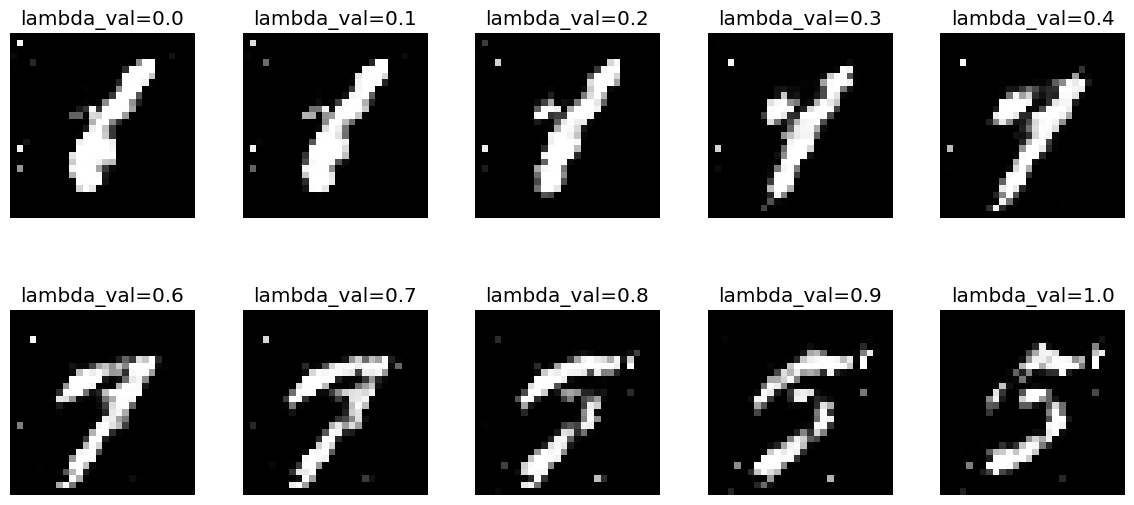

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent).view(-1, 1, 28, 28)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, device=device)
latent_2 = torch.randn(1, 100, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')
plt.show() 

In [20]:
# Save Models
if not os.path.exists('./models'):
    os.mkdir('./models')
            
torch.save(generator.state_dict(), './models/MLP-generator.pth')
torch.save(discriminator.state_dict(),'./models/MLP-discriminator.pth')